## Import Libraries

In [59]:
import pandas as pd 
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline
import pandas as pd 
from tabulate import tabulate

In [60]:
train1 = pd.read_csv('train_month_3_with_target.csv')
train2 = pd.read_csv('train_month_2.csv')
train3 = pd.read_csv('train_month_1.csv')
test1 = pd.read_csv('test_month_3.csv')
test2 = pd.read_csv('test_month_2.csv')
test3 = pd.read_csv('test_month_1.csv')

## Dataset type info

In [61]:
#train1.info()
train1.describe()
train1.isna().any()
train1.dtypes

client_id                             object
homebanking_active                     int64
has_homebanking                        int64
has_insurance_21                       int64
has_insurance_23                       int64
has_life_insurance_fixed_cap           int64
has_life_insurance_decreasing_cap      int64
has_fire_car_other_insurance           int64
has_personal_loan                      int64
has_mortgage_loan                      int64
has_current_account                    int64
has_pension_saving                     int64
has_savings_account                    int64
has_savings_account_starter            int64
has_current_account_starter            int64
bal_insurance_21                       int64
bal_insurance_23                       int64
cap_life_insurance_fixed_cap           int64
cap_life_insurance_decreasing_cap      int64
prem_fire_car_other_insurance          int64
bal_personal_loan                      int64
bal_mortgage_loan                      int64
bal_curren

In [62]:
pd.set_option('display.max_columns',None)


In [63]:
train1['customer_since_all'] = pd.to_datetime(train1['customer_since_all'])
train1['customer_since_bank'] = pd.to_datetime(train1['customer_since_bank'])
train1['customer_birth_date'] = pd.to_datetime(train1['customer_birth_date'])

## Continuous vs Categorical features

In [64]:
cat_vars = []
cont_vars = []
columns = list(train1.drop(columns = ['client_id']).columns)
for i in columns:
    if (len(train1.loc[:,i].unique()) >= 20):
        cont_vars.append(i)
    else:
        cat_vars.append(i)
        
print('Continious variables are:',cont_vars)
print('------------------')
print('Categorical variables are:',cat_vars)
# Here we have our list of categorical and continious variables

Continious variables are: ['bal_insurance_21', 'bal_insurance_23', 'cap_life_insurance_fixed_cap', 'cap_life_insurance_decreasing_cap', 'prem_fire_car_other_insurance', 'bal_personal_loan', 'bal_mortgage_loan', 'bal_current_account', 'bal_pension_saving', 'bal_savings_account', 'bal_savings_account_starter', 'bal_current_account_starter', 'customer_since_all', 'customer_since_bank', 'customer_birth_date', 'customer_postal_code']
------------------
Categorical variables are: ['homebanking_active', 'has_homebanking', 'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap', 'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance', 'has_personal_loan', 'has_mortgage_loan', 'has_current_account', 'has_pension_saving', 'has_savings_account', 'has_savings_account_starter', 'has_current_account_starter', 'visits_distinct_so', 'visits_distinct_so_areas', 'customer_gender', 'customer_occupation_code', 'customer_self_employed', 'customer_education', 'customer_children', 

## Categorical features unique values

In [65]:
# To check we will print all unique values
for col in cat_vars:
    print(col,train1[col].unique())

homebanking_active [0 1]
has_homebanking [0 1]
has_insurance_21 [0 1]
has_insurance_23 [0 1]
has_life_insurance_fixed_cap [0 1]
has_life_insurance_decreasing_cap [0 1]
has_fire_car_other_insurance [1 0]
has_personal_loan [0 1]
has_mortgage_loan [0 1]
has_current_account [1 0]
has_pension_saving [0 1]
has_savings_account [1 0]
has_savings_account_starter [0 1]
has_current_account_starter [0 1]
visits_distinct_so [1. 2. 3. 4. 6. 5. 7.]
visits_distinct_so_areas [1. 2. 3. 5. 4. 6.]
customer_gender [1 2]
customer_occupation_code [ 9. nan  7.  8.  4.  5.  0.  6.  3.  1.  2.]
customer_self_employed [0 1]
customer_education [ 0. nan  2.  1.  4.  3.  5.  6.]
customer_children [nan 'mature' 'no' 'young' 'preschool' 'adolescent' 'grownup' 'onebaby'
 'yes']
customer_relationship [nan 'couple' 'single']
target [0 1]


# Colums with missing Data

In [66]:
missing_df = train1.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['%']=(missing_df['missing values'])/train1.shape[0]*100
missing_df = missing_df[missing_df['missing values'] >0].sort_values('%')
missing_df

,variable,missing values,%
29,customer_since_all,234,0.367364
30,customer_since_bank,249,0.390913
34,customer_occupation_code,2002,3.143005
38,customer_relationship,14899,23.390427
37,customer_children,23364,36.679906
36,customer_education,47125,73.983076


## Data Cleaning

## Approach 1: Understand how to deal with variables with large amount of missing values

We will explore the following columns to see how can we deal with the missing values:
-    customer_education
-    customer_occupation_code
-    customer_relationship
-    customer_children



In [67]:
missing_df2 = missing_df[missing_df['missing values'] >250]
for col in missing_df2['variable']:
    print(col,train1[col].unique())

customer_occupation_code [ 9. nan  7.  8.  4.  5.  0.  6.  3.  1.  2.]
customer_relationship [nan 'couple' 'single']
customer_children [nan 'mature' 'no' 'young' 'preschool' 'adolescent' 'grownup' 'onebaby'
 'yes']
customer_education [ 0. nan  2.  1.  4.  3.  5.  6.]


customer_education

<AxesSubplot:xlabel='customer_education', ylabel='count'>

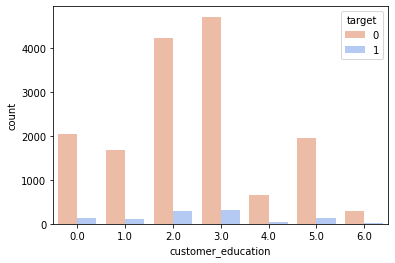

In [68]:
sns.countplot(x='customer_education',data=train1,hue='target',palette="coolwarm_r")

### customer_occupation_code 

-   Most of the clients's job code is equal to 9.
-   From the plot above, we can't see a direct relationship between job code and current balance.\
-> customer_occupation_code feature will be dropped.

In [69]:
for x in range(0,10):
    print(f'job_code {x}', len(train1.loc[(train1['customer_occupation_code']==x)]))

job_code 0 421
job_code 1 24
job_code 2 7
job_code 3 10
job_code 4 1639
job_code 5 153
job_code 6 183
job_code 7 104
job_code 8 318
job_code 9 58836


<AxesSubplot:xlabel='customer_occupation_code', ylabel='count'>

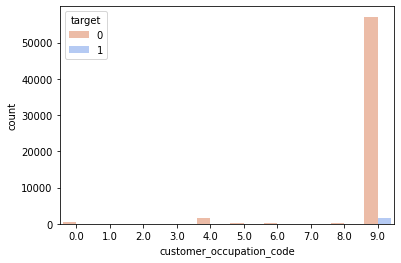

In [70]:
sns.countplot(x='customer_occupation_code',data=train1,hue='target',palette="coolwarm_r")

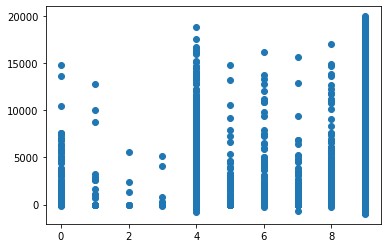

In [71]:
plt.scatter(train1['customer_occupation_code'], train1['bal_current_account'])

### customer_relationship 

Among the non-missing data, the table below describes the proportion of customers churned if they are single or in a couple. 
We have approxiatemtly the same proportion of churners whether they are a couple or single. 

In [72]:
a = len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 0)])+len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 1)]) 

b = len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 0)])+ len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 1)]) 
table=[['Relationship','0','1'],
        [str(len(train1.loc[(train1['customer_relationship']=='couple')])) + ' Couple',round(len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 0)])/a,2 ),round(len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 1)])/a,2) ],
        [str(len(train1.loc[(train1['customer_relationship']=='single')])) + ' Single',round(len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 0)])/b,2) ,round(len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 1)])/b,2) ]]
print(tabulate(table, headers='firstrow'))

Relationship       0     1
--------------  ----  ----
36179 Couple    0.97  0.03
12619 Single    0.97  0.03


### customer_children

In [73]:
rep = {'mature':1,'no':0, 'young':1,'preschool':1,'adolescent':1,'grownup':1,'onebaby':1
 ,'yes':1}
train1['customer_children']= train1['customer_children'].replace(rep) 

In [74]:
c = len(train1.loc[(train1['customer_children']==0) & (train1['target']== 0)])+len(train1.loc[(train1['customer_children']==0) & (train1['target']== 1)]) 

d = len(train1.loc[(train1['customer_children']==1) & (train1['target']== 0)])+ len(train1.loc[(train1['customer_children']==1) & (train1['target']== 1)]) 
table=[['Children','0','1'],
        [str(len(train1.loc[(train1['customer_children']==0)])) + ' Without kids',round(len(train1.loc[(train1['customer_children']==0) & (train1['target']== 0)])/c,2 ),round(len(train1.loc[(train1['customer_children']==0) & (train1['target']== 1)])/c,2) ],
        [str(len(train1.loc[(train1['customer_children']==1)])) + ' With kids',round(len(train1.loc[(train1['customer_children']==1) & (train1['target']== 0)])/d,2) ,round(len(train1.loc[(train1['customer_children']==1) & (train1['target']== 1)])/d,2) ]]
print(tabulate(table, headers='firstrow'))

Children               0     1
------------------  ----  ----
22886 Without kids  0.98  0.02
17447 With kids     0.96  0.04


In [ ]:
sns.countplot(x='customer_children',data=train1,hue='target',palette="coolwarm_r")

ppl w/o home banking active tend to churn less. is there a diff between that and has_homebanking? 
insurance 21 or 23 -> if not then don't churn, noone who has it churned? 
fixed insurance cap, very low amount of ppl have it. 
decreasing cap seems interesting. 
fire car insurance interesting.
not many ppl w personal loan, same for mortgage. 
current account seems to have effect on churn 
no churn if pension savings.
gender does seems to have a low effect on churn. 
more chrun if occupation code =9
seems like having children might have an effect but have to reformat that var. 
ppl in couple seem to churn more.

## Dealing with customer relationship and children missing data  

<AxesSubplot:xlabel='customer_children', ylabel='count'>

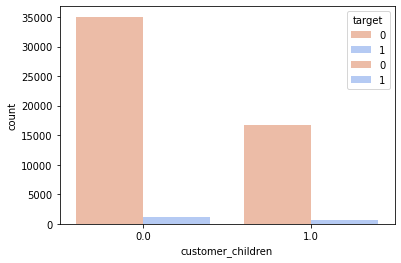

In [75]:
sns.countplot(x='customer_relationship',data=train1,hue='target',palette="coolwarm_r")
sns.countplot(x='customer_children',data=train1,hue='target',palette="coolwarm_r")


## Approach 2: Delete 4 columns 

In [ ]:
train1.drop(['customer_children','customer_relationship','customer_occupation_code','customer_education',
                'client_id'],axis=1, inplace=True) 

In [ ]:
train1.shape

In [ ]:
train1.dropna(axis=0, inplace=True) 
train1.shape

## Handling Date Columns

 - customer_since_all
 - customer_since_bank
 - customer_birth_date

We will not strip the day from 'customer_since_all', 'customer_since_bank' because all have the same value = 01. 

In [ ]:
train1['Birth_year'] = train1['customer_birth_date'].dt.strftime('%Y').astype(str).astype(int)

train1['Year_since_all'] = train1['customer_since_all'].dt.strftime('%Y').astype(str).astype(int)
train1['Month_since_all'] = train1['customer_since_all'].dt.strftime('%m').astype(str).astype(int)


train1['Year_since_bank'] = train1['customer_since_bank'].dt.strftime('%Y').astype(str).astype(int)
train1['Month_since_bank'] = train1['customer_since_bank'].dt.strftime('%m').astype(str).astype(int)


In [ ]:
train1.drop(['customer_since_all','customer_since_bank','customer_birth_date'], axis=1, inplace=True)

In [ ]:
train1.drop(train1[train1['Birth_year'] < 1919].index, inplace = True)

In [ ]:
train1.shape

In [ ]:
train1

## feature engineering 
- We could see if there is a significant (large) difference in say balance or savings as this could be an indicator that the client is about to churn. (can just be stored as a boolean). 
- can also compute a boolean regarding the change in some services that the client has. Say he dropped in insurrance 21 last month or smtg. also as a boolean 


## regarding modeling
the most used techniques are logistic regression, random forest, xgboost. People usually use random forest as a baseline reference and then they tune it or try other models to see if they can beat the random forest. 

## STEPS REQUIRED
## A-Identify Business Problems
- What is the likelihood of an active customer to leave the bank?
- What are the key indicators of a customer churn?
- What retention strategies can be implemented based on results to diminish prospective customer churn?




## STEPS REQUIRED
## A-Identify Business Problems
- What is the likelihood of an active customer to leave the bank?
- What are the key indicators of a customer churn?
- What retention strategies can be implemented based on results to diminish prospective customer churn?




## C- Data Evaluation
- Plot Charts and Histograms
- Analyze the distribution of categorical variables
- Analyze the churn rate by variable
- Find correlations between variables
- Making a conclusion from the above findings
- Split the dataset in training and validation sets
- Split the dependent variable from the independent variables.
- Remove Identifier: Customer ID
- Normalize Variables

## D- Model Selection
Suggested models:
- Logistic Regression
- Random Forrest
- KNN
- SVM
-xgboost

## E- Model Evalation


## F- Model Improvement
Tuning Hyperparameters

## G- Model Deployement

## Resources